<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [ ]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [ ]:
!pip install - q pymatgen
!pip install - q stellargraph

     |████████████████████████████████| 40.6 MB 1.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 65 kB 3.6 MB/s 
     |████████████████████████████████| 109 kB 63.7 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 292 kB 44.0 MB/s 
     |████████████████████████████████| 98 kB 3.4 MB/s 
     |████████████████████████████████| 546 kB 37.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 435 kB 5.4 MB/s 
     |████████████████████████████████| 462 kB 40.8 MB/s 


In [ ]:
import gc
import random
import tensorflow as tf
from keras import backend as KE
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from pymatgen.core import Lattice, Structure, Molecule
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor, LGBMClassifier
import json
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
from tqdm.keras import TqdmCallback
import networkx as nx
import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator, FullBatchLinkGenerator
from stellargraph import StellarGraph
from stellargraph.layer import DeepGraphCNN, GCN
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

gc.enable()

In [ ]:
private = "1OFmiprkJwvwWL9MnCxGFvp1l_IDwI79x"
public = "1f2I_YMV0NY8bFw2jZN4TIekNcx8KLbOG"

In [ ]:
gdd.download_file_from_google_drive(file_id=private, dest_path='./private.tar.gz', unzip=False)
gdd.download_file_from_google_drive(file_id=public, dest_path='./public.tar.gz', unzip=False)

!tar -xzvf  private.tar.gz >/dev/null 2>&1
!tar -xzvf  public.tar.gz >/dev/null 2>&1

In [ ]:
private = "dichalcogenides_private/"
public = "dichalcogenides_public/"

targets = pd.read_csv(public+'targets.csv')
dict_Y = dict(zip(targets['_id'].values.tolist(),
              targets['band_gap'].values.tolist()))

In [ ]:
def read_pymaten_structure(path_to_file):
    with open(path_to_file, "r") as f:
        d = json.load(f)
        structure = Structure.from_dict(d)
    return structure

In [ ]:
files = list(os.listdir(public + 'structures/'))
np.random.seed(8)
np.random.shuffle(files)
train_files = files[:-100][:]
valid_files = files[-100:][:]

In [ ]:
def rmj(s):
    s = s.replace('.json', '')
    return s

In [ ]:
def read_jmol_graph(path):
    A = pd.read_csv(path)
    G = nx.from_numpy_matrix((np.exp(A.values) * (A.values > 1).astype('int')))
    return G, A.values

In [ ]:
def st2df(st):
    df_st = st.as_dataframe()
    df_st[['x', 'y', 'z']] = st.frac_coords
    an = st.atomic_numbers
    df_st['an'] = an
    df_st['an'] = df_st['an']
    df_st = df_st[['x', 'y', 'z', 'a', 'b', 'c', 'an']]

    return df_st

In [ ]:
def pad(l, maxlen=200):
    l = tf.keras.preprocessing.sequence.pad_sequences([l], maxlen=200,
                                                      dtype='float32', padding='pre',
                                                      truncating='pre', value=-1)[0]
    return l.tolist()

In [ ]:
def get_mean_neighbors(arr, node):
    neigh = np.argwhere(arr[node, :] > 0)
    mean_neighbors = arr[neigh, :].mean(axis=0)
    return mean_neighbors.ravel().tolist()

In [ ]:
arr = np.random.normal(size=(100, 10))
get_mean_neighbors(arr, 10)

[0.9940636116847967,
 0.2205011342409137,
 0.04258111713775703,
 -1.5698193839869106,
 -0.14719155382646673,
 -0.05318446756898454,
 -0.1938113786382707,
 -0.9301300346190953,
 0.29300529188582924,
 -0.5348903680032641]

In [ ]:
def annotate_nodes(df_st, G, A, an):
    # m = pad(get_mean_neighbors(A, node))
    # arr_st = df_st.values

    for node in G.nodes:
        AN = A[node, :].tolist()
        N = get_mean_neighbors(A, node)
        N = pad(N)
        AN = pad(AN)
        AN = AN + N
        G.nodes[node]['feature'] = [an[node], np.exp(-np.std(A[node, :]))] + AN
    return G

In [ ]:
def get_y_classes(x):
    if x <= 0.6:
        return 1
    elif x <= 1.5:
        return 2
    else:
        return 3

In [ ]:
# st = read_pymaten_structure('dichalcogenides_public/structures/6141d33b9cbada84a867692d.json')

In [ ]:
def get_stellar_graphs(path_st, path_g, files):

    size, density, nunique, mean, meandist, stddist, ameans, dmean = [
    ], [], [], [], [], [], [], []
    xmn, ymn, zmn, amn, bmn, cmn = [], [], [], [], [], []
    xsd, ysd, zsd, asd, bsd, csd = [], [], [], [], [], []

    dict_graphs = {}

    for file in tqdm(files):
        st = read_pymaten_structure(path_st + 'structures/' + file)
        an = st.atomic_numbers

        size.append(st.num_sites)
        density.append(st.density)
        nunique.append(len(np.unique(an)))
        mean.append(np.mean(an))

        df_st = st2df(st)

        xmn.append(df_st['x'].mean())
        xsd.append(df_st['x'].std())
        ymn.append(df_st['y'].mean())
        ysd.append(df_st['y'].std())
        zmn.append(df_st['z'].mean())
        zsd.append(df_st['z'].std())

        amn.append(df_st['a'].mean())
        asd.append(df_st['a'].std())
        bmn.append(df_st['b'].mean())
        bsd.append(df_st['b'].std())
        cmn.append(df_st['c'].mean())
        csd.append(df_st['c'].std())

        G, A = read_jmol_graph(path_g + rmj(file) + '.csv')
        A = A * st.density
        G = annotate_nodes(df_st, G, A, an)

        amean = A.mean(axis=0).tolist()
        amean = pad(amean, maxlen=200)

        meandist.append(np.exp(A).mean())
        dmean.append(np.exp(st.distance_matrix).mean())
        stddist.append(np.exp(A).std())
        ameans.append(amean)

        G = StellarGraph.from_networkx(G, node_features='feature')
        dict_graphs[rmj(file)] = G

    X_data = pd.DataFrame()  # (np.array(ameans))
    X_data['size'] = size
    X_data['density'] = density
    X_data['nunique'] = nunique
    X_data['mean'] = mean
    X_data['meandist'] = meandist
    X_data['stddist'] = stddist
    X_data['dmean'] = dmean

    X_data['xmn'] = xmn
    X_data['ymn'] = ymn
    X_data['zmn'] = zmn
    X_data['amn'] = amn
    X_data['bmn'] = bmn
    X_data['cmn'] = cmn

    X_data['xsd'] = xsd
    X_data['ysd'] = ysd
    X_data['zsd'] = zsd
    X_data['asd'] = asd
    X_data['bsd'] = bsd
    X_data['csd'] = csd

    return dict_graphs, X_data

In [ ]:
!unzip  public_JmolNN.zip >/dev/null 2>&1

In [ ]:
dict_graphs_train, X_train = get_stellar_graphs(public, 'public_JmolNN/', train_files)
dict_graphs_valid, X_valid = get_stellar_graphs(public, 'public_JmolNN/', valid_files)

Y_train = np.array([dict_Y[k] for k in dict_graphs_train.keys()])
Y_valid = np.array([dict_Y[k] for k in dict_graphs_valid.keys()])

Y_train_class = [get_y_classes(y) for y in Y_train]
Y_valid_class = [get_y_classes(y) for y in Y_valid]

  0%|          | 0/2866 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
clf = LGBMClassifier()
cross_val_score(clf, X_train, Y_train_class, cv=3,
                scoring='accuracy', verbose=3)

clf.fit(X_train, Y_train_class)
Y_train_class_prediction = clf.predict(X_train)
Y_valid_class_prediction = clf.predict(X_valid)

np.mean(Y_train_class == Y_train_class_prediction), np.mean(
    Y_valid_class == Y_valid_class_prediction)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=1.000) total time=   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END ................................ score: (test=1.000) total time=   0.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] END ................................ score: (test=1.000) total time=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s finished


(1.0, 1.0)

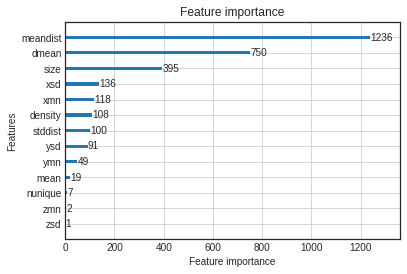

In [ ]:
from lightgbm import plot_importance

plot_importance(clf, max_num_features=20)

In [ ]:
Y_train[Y_train_class != Y_train_class_prediction]

array([], dtype=float64)

In [ ]:
def get_generators(dict_graphs, index, k):
    graphs = []
    for v, i in zip(dict_graphs.values(), index):
        if i == k:
            graphs.append(v)

    print(f"{len(graphs)} in  {k}")

    gen = PaddedGraphGenerator(graphs=graphs)

    return gen

In [ ]:
from sklearn.preprocessing import QuantileTransformer

qt_1 = QuantileTransformer(n_quantiles=len(Y_train),
                           random_state=7,
                           output_distribution='normal')

qt_2 = QuantileTransformer(n_quantiles=len(Y_train),
                           random_state=7,
                           output_distribution='normal')

qt_3 = QuantileTransformer(n_quantiles=len(Y_train),
                           random_state=7,
                           output_distribution='normal')

In [ ]:
def normalize(x, qt):
    x = x.reshape(-1, 1)
    x = qt.transform(x)
    return x

In [ ]:
print('train: ')
generator_train_1 = get_generators(dict_graphs_train, Y_train_class_prediction, 1)
generator_train_2 = get_generators(dict_graphs_train, Y_train_class_prediction, 2)
generator_train_3 = get_generators(dict_graphs_train, Y_train_class_prediction, 3)

Y_train_class_prediction = np.array(Y_train_class_prediction)
Y_train_1 = Y_train[Y_train_class_prediction == 1]
Y_train_2 = Y_train[Y_train_class_prediction == 2]
Y_train_3 = Y_train[Y_train_class_prediction == 3]

# qt_1 = qt_1.fit(Y_train_1.reshape(-1, 1))
# qt_2 = qt_2.fit(Y_train_2.reshape(-1, 1))
# qt_3 = qt_3.fit(Y_train_3.reshape(-1, 1))

# Y_train_1 = normalize(Y_train_1, qt_1)
# Y_train_2 = normalize(Y_train_2, qt_2)
# Y_train_3 = normalize(Y_train_3, qt_3)


print('valid: ')
generator_valid_1 = get_generators(dict_graphs_valid, Y_valid_class_prediction, 1)
generator_valid_2 = get_generators(dict_graphs_valid, Y_valid_class_prediction, 2)
generator_valid_3 = get_generators(dict_graphs_valid, Y_valid_class_prediction, 3)

Y_valid_class_prediction = np.array(Y_valid_class_prediction)
Y_valid_1 = Y_valid[Y_valid_class_prediction == 1]
Y_valid_2 = Y_valid[Y_valid_class_prediction == 2]
Y_valid_3 = Y_valid[Y_valid_class_prediction == 3]

# Y_valid_1 = normalize(Y_valid_1, qt_1)
# Y_valid_2 = normalize(Y_valid_2, qt_2)
# Y_valid_3 = normalize(Y_valid_3, qt_3)

train: 
1408 in  1
1100 in  2
358 in  3
valid: 
50 in  1
34 in  2
16 in  3


In [ ]:
plt.hist(Y_train_1, bins=164)
plt.hist(Y_valid_1, bins=164)

In [ ]:
# https://github.com/materialsvirtuallab/megnet/blob/master/megnet/models/megnet.py

def softplus2(x):
    """
    out = log(exp(x)+1) - log(2)
    softplus function that is 0 at x=0, the implementation aims at avoiding overflow
    Args:
        x: (Tensor) input tensor
    Returns:
         (Tensor) output tensor
    """
    return KE.relu(x) + KE.log(0.5 * KE.exp(-KE.abs(x)) + 0.5)

In [ ]:
def get_model(generator):

    k = 128
    layer_sizes = [64, 64, 32]

    dgcnn_model = DeepGraphCNN(
        layer_sizes=layer_sizes,
        activations=['tanh']*len(layer_sizes),
        k=k,
        bias=True,
        # kernel_regularizer='l2',
        # dropout = 0.01,
        generator=generator,
    )
    x_inp, x_out = dgcnn_model.in_out_tensors()
    x_out = Conv1D(filters=256, kernel_size=sum(layer_sizes),
                   strides=sum(layer_sizes), activation=softplus2)(x_out)
    x_out = tf.keras.layers.AveragePooling1D(pool_size=2)(x_out)
    x_out = Flatten()(x_out)

    x_out = Dense(units=32, activation=softplus2)(x_out)
    # tfa.layers.NoisyDense(
    x_out = Dense(units=16, activation=softplus2)(x_out)
    # x_out = Dropout(rate=0.1)(x_out)

    predictions = Dense(units=1)(x_out)
    model = Model(inputs=x_inp, outputs=predictions)

    model.compile(optimizer='adam', loss='mae')
    return model

In [ ]:
model_1, model_2, model_3 = None,  None,  None

if not model_1:
    model_1 = get_model(generator_train_1)

if not model_2:
    model_2 = get_model(generator_train_2)

if not model_3:
    model_3 = get_model(generator_train_3)

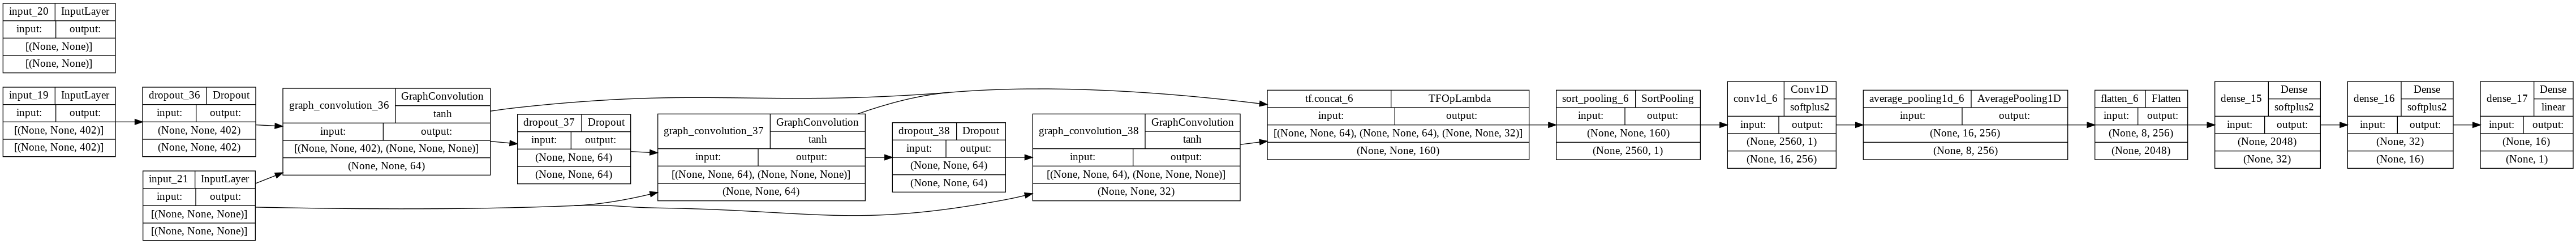

In [ ]:
tf.keras.utils.plot_model(model_1, rankdir='LR',
                          show_shapes=True,
                          show_layer_activations=True)

In [ ]:
def get_train_valid_gen(generator_train, generator_valid,
                        Y_train, Y_valid, batch_size):

    train_gen = generator_train.flow(
        list(range(len(Y_train))),
        targets=Y_train,
        batch_size=batch_size,
        symmetric_normalization=True,
        shuffle=True,
        weighted=True
    )

    valid_gen = generator_valid.flow(
        list(range(len(Y_valid))),
        targets=Y_valid,
        batch_size=100,
        symmetric_normalization=True,
        shuffle=False,
        weighted=True
    )

    return train_gen, valid_gen

In [ ]:
train_gen_1, valid_gen_1 = get_train_valid_gen(generator_train_1, generator_valid_1,
                                               Y_train_1, Y_valid_1, 64)

train_gen_2, valid_gen_2 = get_train_valid_gen(generator_train_2, generator_valid_2,
                                               Y_train_2, Y_valid_2, 32)

train_gen_3, valid_gen_3 = get_train_valid_gen(generator_train_3, generator_valid_3,
                                               Y_train_3, Y_valid_3, 16)

In [ ]:
def scheduler(epoch, lr):
    decay_rate = 0.85
    decay_step = 50
    if epoch % decay_step == 0 and epoch:
        lr = lr * pow(decay_rate, np.floor(epoch / decay_step))
        print(lr)
        lr = max(0.00003, lr)
        return lr
    return lr


def train(model, train_gen, valid_gen, LR=0.0001):

    lrs = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=500)  # , restore_best_weights=True

    KE.set_value(model.optimizer.learning_rate, LR)
    history = model.fit(train_gen,
                        epochs=1000,
                        verbose=0,
                        validation_data=valid_gen,
                        callbacks=[TqdmCallback(), earlystop, lrs])

    return model, history

In [ ]:
model_1, history_1 = train(model_1, train_gen_1, valid_gen_1)

sg.utils.plot_history(history_1)  # loss=0.024, val_loss=0.0307

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_9/sort_pooling_9/map/while/gradients/model_9/sort_pooling_9/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_9/sort_pooling_9/map/while/gradients/model_9/sort_pooling_9/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_9/sort_pooling_9/map/while/gradients/model_9/sort_pooling_9/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


8.499999785271939e-05
6.14124997628096e-05
3.771495276851055e-05
1.968744053663158e-05
1.3311159038731828e-05
1.1314485182922054e-05
9.617312405483745e-06


KeyboardInterrupt: ignored

In [ ]:
model_2, history_2 = train(model_2, train_gen_2, valid_gen_2)

sg.utils.plot_history(history_2)  # loss=0.0247, val_loss=0.0127

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_10/sort_pooling_10/map/while/gradients/model_10/sort_pooling_10/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_10/sort_pooling_10/map/while/gradients/model_10/sort_pooling_10/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_10/sort_pooling_10/map/while/gradients/model_10/sort_pooling_10/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


8.499999785271939e-05
6.14124997628096e-05
3.771495276851055e-05
1.968744053663158e-05


KeyboardInterrupt: ignored

In [ ]:
model_3, history_3 = train(model_3, train_gen_3, valid_gen_3, 0.0001)

sg.utils.plot_history(history_3)  # loss=0.0128, val_loss=0.0121

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_11/sort_pooling_11/map/while/gradients/model_11/sort_pooling_11/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_11/sort_pooling_11/map/while/gradients/model_11/sort_pooling_11/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_11/sort_pooling_11/map/while/gradients/model_11/sort_pooling_11/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


8.499999785271939e-05
6.14124997628096e-05
3.771495276851055e-05
1.968744053663158e-05
1.3311159038731828e-05
1.1314485182922054e-05
9.617312405483745e-06
8.174715544661183e-06
6.948508212962005e-06


KeyboardInterrupt: ignored

In [ ]:
def tolist(p):
    p = p.ravel().tolist()
    return p

In [ ]:
def get_steps_indecies(Y_class):

    index_1 = np.argwhere(Y_class == 1)
    index_2 = np.argwhere(Y_class == 2)
    index_3 = np.argwhere(Y_class == 3)

    index_1 = tolist(np.argwhere(Y_class == 1))
    index_2 = tolist(np.argwhere(Y_class == 2))
    index_3 = tolist(np.argwhere(Y_class == 3))

    num_steps_1 = len(index_1)
    num_steps_2 = len(index_2)
    num_steps_3 = len(index_3)

    return num_steps_1, num_steps_2, num_steps_3, index_1, index_2, index_3

In [ ]:
def predict(model_1, model_2, model_3,
            test_gen_1, test_gen_2, test_gen_3,
            num_steps_1, num_steps_2, num_steps_3,
            index_1, index_2, index_3):

    predictions_1 = model_1.predict(test_gen_1, steps=num_steps_1, verbose=1)
    predictions_2 = model_2.predict(test_gen_2, steps=num_steps_2, verbose=1)
    predictions_3 = model_3.predict(test_gen_3, steps=num_steps_3, verbose=1)

    predictions_1 = tolist(predictions_1)
    predictions_2 = tolist(predictions_2)
    predictions_3 = tolist(predictions_3)

    # predictions_1 = qt_1.inverse_transform(np.array(predictions_1).reshape(-1, 1)).ravel().tolist()

    predictions = predictions_1 + predictions_2 + predictions_3

    index = index_1 + index_2 + index_3
    predictions = list(zip(predictions, index))
    predictions.sort(key=lambda x: x[1])

    print("Looks like that :")
    print(predictions[:2])

    predictions = [p[0] for p in predictions]
    # predictions = tolist((10**np.array(predictions)))

    return predictions

In [ ]:
def get_test_gen(generator_test, Y_test):

    test_gen = generator_test.flow(list(range(len(Y_test))),
                                   targets=Y_test,
                                   batch_size=1,
                                   symmetric_normalization=True,
                                   shuffle=False,
                                   weighted=True)

    return test_gen

In [ ]:
num_steps_1, num_steps_2, num_steps_3, index_1, index_2, index_3 = get_steps_indecies(Y_train_class_prediction)

In [ ]:
test_gen_1 = get_test_gen(generator_train_1, Y_train_1)
test_gen_2 = get_test_gen(generator_train_2, Y_train_2)
test_gen_3 = get_test_gen(generator_train_3, Y_train_3)

train_predictions = predict(model_1, model_2, model_3,
                            test_gen_1, test_gen_2, test_gen_3,
                            num_steps_1, num_steps_2, num_steps_3,
                            index_1, index_2, index_3)

358/358 [==============================] - 3s 8ms/step
Looks like that :
[(1.146055817604065, 0), (1.144529104232788, 1)]


0.7128401953942778


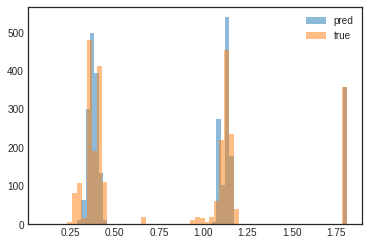

In [ ]:
d = pd.DataFrame()
d['pred'] = train_predictions
d['true'] = Y_train

d['res'] = (d['pred']-d['true']).abs()
eps = 0.02
print(np.mean(d['res'] < eps))

plt.hist(d['pred'], label='pred', alpha=0.5, bins=62)
plt.hist(d['true'], label='true', alpha=0.5, bins=62)
plt.legend() 

In [ ]:
d.head()

,pred,true,res
0,1.146056,1.1470,0.000944
1,1.144529,1.1448,0.000271
2,1.809879,1.8066,0.003279
3,1.809177,1.8072,0.001977
4,0.352590,0.2549,0.097690


In [ ]:
X_train['pred_gcn'] = train_predictions

In [ ]:
X_train.head()

,size,density,nunique,mean,meandist,stddist,dmean,xmn,ymn,zmn,amn,bmn,cmn,xsd,ysd,zsd,asd,bsd,csd,pred_gcn
0,191,2.047013,4,24.973822,1.289626,1.671717,159953.571935,0.507853,0.493455,0.249449,0.507853,0.493455,0.249449,0.288314,0.288537,0.085985,0.288314,0.288537,0.085985,1.146056
1,191,2.047013,4,24.973822,1.289626,1.671717,159953.571907,0.509162,0.495419,0.249449,0.509162,0.495419,0.249449,0.286941,0.286717,0.085985,0.286941,0.286717,0.085985,1.144529
2,192,2.062634,4,25.020833,1.294225,1.703126,160033.872411,0.506944,0.493056,0.250000,0.506944,0.493056,0.250000,0.287834,0.287834,0.086099,0.287834,0.287834,0.086099,1.809879
3,192,2.062634,4,25.020833,1.294225,1.703126,160033.872411,0.506944,0.493056,0.250000,0.506944,0.493056,0.250000,0.287834,0.287834,0.086099,0.287834,0.287834,0.086099,1.809177
4,189,1.995023,2,24.666667,1.270055,1.561227,159993.865451,0.507937,0.490079,0.251113,0.507937,0.490079,0.251113,0.289715,0.288936,0.086095,0.289715,0.288936,0.086095,0.352590


In [ ]:
rg = LGBMRegressor()
cross_val_score(rg, X_train.values, Y_train, cv=3,
                scoring='neg_mean_squared_error', verbose=3)

rg.fit(X_train.values, Y_train)
pred = rg.predict(X_train.values)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-0.001) total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END ............................... score: (test=-0.001) total time=   0.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] END ............................... score: (test=-0.001) total time=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished


0.8775296580600139


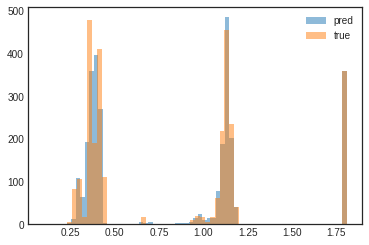

In [ ]:
d = pd.DataFrame()
d['pred'] = pred.ravel()
d['true'] = Y_train

d['res'] = (d['pred']-d['true']).abs()
eps = 0.02
print(np.mean(d['res'] < eps))

plt.hist(d['pred'], label='pred', alpha=0.5, bins=62)
plt.hist(d['true'], label='true', alpha=0.5, bins=62)
plt.legend()

In [ ]:
!unzip  private_JmolNN.zip >/dev/null 2>&1

In [ ]:
test_files = list(os.listdir(private + 'structures/'))
dict_graphs_test, X_test = get_stellar_graphs(private, 'private_JmolNN/', test_files)

Y_test_class_prediction = clf.predict(X_test)

  0%|          | 0/2967 [00:00<?, ?it/s]

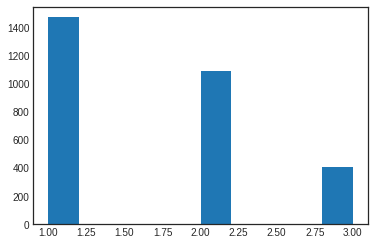

In [ ]:
plt.hist(Y_test_class_prediction);

In [ ]:
generator_test_1 = get_generators(dict_graphs_test, Y_test_class_prediction, 1)
generator_test_2 = get_generators(dict_graphs_test, Y_test_class_prediction, 2)
generator_test_3 = get_generators(dict_graphs_test, Y_test_class_prediction, 3)

Y_test_class_prediction = np.array(Y_test_class_prediction)
Y_test_1 = Y_test_class_prediction[Y_test_class_prediction == 1]
Y_test_2 = Y_test_class_prediction[Y_test_class_prediction == 2]
Y_test_3 = Y_test_class_prediction[Y_test_class_prediction == 3]

1474 in  1
1088 in  2
405 in  3


In [ ]:
num_steps_1, num_steps_2, num_steps_3, index_1, index_2, index_3 = get_steps_indecies(Y_test_class_prediction)

In [ ]:
test_gen_1 = get_test_gen(generator_test_1, Y_test_1)
test_gen_2 = get_test_gen(generator_test_2, Y_test_2)
test_gen_3 = get_test_gen(generator_test_3, Y_test_3)

test_predictions = predict(model_1, model_2, model_3,
                           test_gen_1, test_gen_2, test_gen_3,
                           num_steps_1, num_steps_2, num_steps_3,
                           index_1, index_2, index_3)

405/405 [==============================] - 4s 9ms/step
Looks like that :
[(0.37613987922668457, 0), (0.39841967821121216, 1)]


In [ ]:
sub = pd.read_csv('submission.csv')
sub.head()

,id,predictions
0,6141d2bebaaf234b352902c2,1.100498
1,61422f8c31cf3ef3d4a9f3a0,0.384446
2,6141cf2f9cbada84a86767ed,1.808320
3,6141d16cbaaf234b35290282,1.101272
4,6141d4f9ee0a3fd43fb47b7f,0.359615


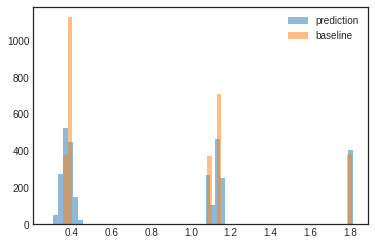

In [ ]:
plt.hist(test_predictions, bins=62, alpha=0.5, label='prediction')
plt.hist(sub.predictions, bins=62, alpha=0.5, label='baseline')
plt.legend()

In [ ]:
X_test['pred_gcn'] = test_predictions
test_predictions = rg.predict(X_test.values)

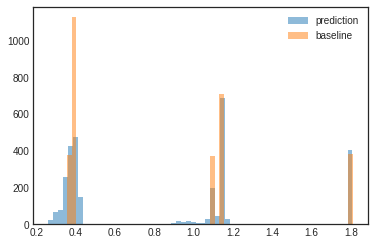

In [ ]:
plt.hist(test_predictions, bins=62, alpha=0.5, label='prediction')
plt.hist(sub.predictions, bins=62, alpha=0.5, label='baseline')
plt.legend()

In [ ]:
map_test = dict(zip([rmj(f) for f in test_files], test_predictions))

In [ ]:
sub['predictions2'] = sub.id.map(map_test)

In [ ]:
sub['res'] = (sub['predictions2']-sub['predictions']).abs()
eps = 0.02
print(np.mean(sub['res'] < eps))

1.0


In [ ]:
sub.head()

,id,predictions,predictions2,res
0,6141d2bebaaf234b352902c2,0.636872,0.636872,0.0
1,61422f8c31cf3ef3d4a9f3a0,0.387958,0.387958,0.0
2,6141cf2f9cbada84a86767ed,1.807895,1.807895,0.0
3,6141d16cbaaf234b35290282,0.979842,0.979842,0.0
4,6141d4f9ee0a3fd43fb47b7f,0.346744,0.346744,0.0


In [ ]:
sub['predictions'] = sub.predictions2

In [ ]:
sub[['id', 'predictions']].to_csv('submission_2_3_4.csv', index = False)

In [ ]:
model_1.save('model_1o.hdf5')

In [ ]:
model_2.save('model_2o.hdf5')

In [ ]:
model_3.save('model_3o.hdf5')